In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #绘图模块，基于matplotlib的可视化python包,不能完全替代matplotlib,只是对matplotlib进行升级
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

# 1 数据导入

In [2]:
#parse_dates:将指定的列加载成日期的格式
offline = pd.read_csv('./train.csv',parse_dates=['date_received','date'])
offline.info()  #175+万条数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648881 entries, 0 to 1648880
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        1648881 non-null  int64         
 1   merchant_id    1648881 non-null  int64         
 2   coupon_id      947279 non-null   float64       
 3   discount_rate  947279 non-null   object        
 4   distance       1648881 non-null  int64         
 5   date_received  947279 non-null   datetime64[ns]
 6   date           768767 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 88.1+ MB


In [3]:
offline.head(20) #NaT:时间日期格式的空值

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,NaN,NaN,0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0,2016-06-13,NaT
5,1439408,2632,NaN,NaN,0,NaT,2016-05-16
6,1439408,2632,8591.0,20:1,0,2016-05-16,2016-06-13
7,1832624,3381,7610.0,200:20,0,2016-04-29,NaT
8,2029232,3381,11951.0,200:20,1,2016-01-29,NaT
9,2029232,450,1532.0,30:5,0,2016-05-30,NaT


# 2 数据规整

In [4]:
#判断每一列当中有多少个空值
offline.isnull().sum()
#优惠券id，折扣率，领券日期，三者可能存在同时==null的情况

user_id               0
merchant_id           0
coupon_id        701602
discount_rate    701602
distance              0
date_received    701602
date             880114
dtype: int64

## 2.1 把“discount_rate”列中的满减政策转换成折扣率

In [5]:
offline['discount_rate'] = offline['discount_rate'].fillna('null')
offline.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,NaN,null,0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0,2016-06-13,NaT


In [7]:
def discount_rate_opt(s): #s代表每一个元素
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1]))/int(split[0])
        return round(discount_rate,2)  #折扣率保留两位小数
    elif s == 'null':
        return np.NaN
    else:
        return float(s)

In [8]:
offline['discount_rate']  = offline['discount_rate'].map(discount_rate_opt)
offline.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,NaN,NaN,0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0,2016-06-13,NaT


### 2.2 Coupon_id字段：null代表无优惠券，此时Discount_rate与Date_received字段无意义。
检查Coupon_id和Discount_rate与Date_received判断空值和非空值是否一一对应。

In [9]:
#np.all():判断一个课迭代数据中是否都为True，如果是返回True，否则返回False
np.all([True,False,True])

False

In [10]:
nan1 = offline['coupon_id'].isnull()  #判断优惠券是否为空
nan2 = offline['date_received'].isnull()   #判断领券日期是否为空
np.all(nan1 == nan2)  #如果结果=true，说明之前的猜测：Coupon_id与Date_received空值与非空值是一一对应的关系

True

In [11]:
nan3 = offline['discount_rate'].isnull()
np.all(nan1 == nan3)#如果结果=true，说明之前的猜测：Coupon_id与Discount_rate空值与非空值是一一对应的关系

True

### 2.3
如果Date=null & Coupon_id!=null,有券未消费（cpon_no_consume）
如果Date=null & Coupon_id =null,无券未消费（no_cpon_no_consume）
如果Date！=null & Coupon_id=null,无券消费（no_cpon_consume）
如果Date！=null & Coupon_id!=null,有券消费（cpon_consume）

In [12]:
cpon_no_consume = offline[(offline['date'].isnull() & offline['coupon_id'].notnull())]
no_cpon_no_consume = offline[(offline['date'].isnull() & offline['coupon_id'].isnull())]
no_cpon_consume = offline[(offline['date'].notnull() & offline['coupon_id'].isnull())]
cpon_consume = offline[(offline['date'].notnull() & offline['coupon_id'].notnull())]

In [13]:
print('有券未消费:{}'.format(len(cpon_no_consume)))
print('无券未消费:{}'.format(len(no_cpon_no_consume)))  #无意义，不需分析
print('无券消费:{}'.format(len(no_cpon_consume)))
print('有券消费:{}'.format(len(cpon_consume)))
#用优惠券消费的用7万，相比其他用户来说，占比较少

有券未消费:880114
无券未消费:0
无券消费:701602
有券消费:67165


# 3.数据分析

In [14]:
#绘制饼图占比
consume_status_dict = {'cpon_no_consume':len(cpon_no_consume),'no_cpon_consume':len(no_cpon_consume),'cpon_consume':len(cpon_consume)}
consume_status = pd.Series(consume_status_dict)
consume_status

cpon_no_consume    880114
no_cpon_consume    701602
cpon_consume        67165
dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21344 (\N{CJK UNIFIED IDEOGRAPH-5360}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes

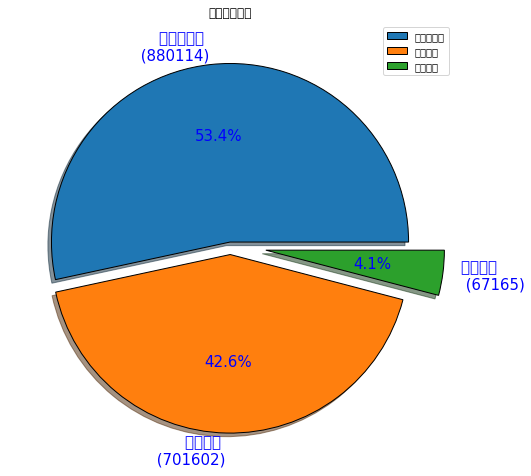

In [15]:
#消费方式构成的饼图（figure：看作是一张画布，axes：代表画布内的多个坐标系）
fig,ax=plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax = ax,
                       autopct='%1.1f%%',
                       shadow=True,
                        explode=[0.02,0.05,0.2],
                        textprops={'fontsize':15,'color':'blue'},
                        wedgeprops={'linewidth':1,'edgecolor':'black'},
                        labels=['有券未消费 \n ({})'.format(len(cpon_no_consume)),
                                '无券消费 \n ({})'.format(len(no_cpon_consume)),
                               '用券消费 \n ({})'.format(len(cpon_consume))
                               ]
                       )
ax.set_ylabel('')  #去除ylable
ax.set_title('消费占比情况')
plt.legend(labels=['有券未消费','无券消费','用券消费'])
#有券未消费占比55.7%最大，说明大多数人拿完券之后，尚未使用
#无圈消费用户占比40%，说明很多人没有使用优惠券，可能优惠券的吸引力不大，客户没在意；可能，新用户比较多。
#用券消费用户占比较小4.3%,说明我们的优惠券使用率不高。可以考虑是不是加大优惠券力度.....

## 3.1在有券消费人群中，分析距离和优惠折扣

In [16]:
#各商家对应的顾客到店平均距离
Merchant_distance = cpon_consume.groupby('merchant_id')['distance'].mean()
Merchant_distance[Merchant_distance==0]
#有4076个商家，有1431个商家的用券消费用户平均范围在500米以内

merchant_id
3       0.0
4       0.0
13      0.0
14      0.0
18      0.0
       ... 
8806    0.0
8824    0.0
8828    0.0
8849    0.0
8856    0.0
Name: distance, Length: 1431, dtype: float64

merchant_id
3       0.670
4       0.830
5       0.750
13      0.900
14      0.830
        ...  
8843    0.930
8844    0.895
8849    0.950
8850    0.950
8856    0.925
Name: discount_rate, Length: 3738, dtype: float64

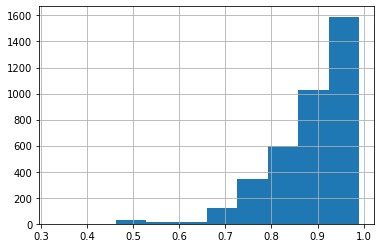

In [17]:
#各商家对应的顾客到店消费平均折扣力度
Merchant_discount_rate = cpon_consume.groupby('merchant_id')['discount_rate'].mean()
Merchant_discount_rate.sort_values()
Merchant_discount_rate.hist()
Merchant_discount_rate.mean()  #所有商家平均折扣的平均值：0.88
Merchant_discount_rate

## 3.2持券到店消费人数最多的商家

In [18]:
#对商家进行分组，取出用户id，对用户id进行去重统计数量、
popular_merchant = cpon_consume.groupby('merchant_id')['user_id'].apply(lambda x:len(x.unique())).sort_values(ascending=False)
#找出持券消费人数>500的商家id
popular_merchant500 = popular_merchant[popular_merchant>500]
popular_merchant500.name = 'customer_count'  #指定列名为消费者数量（持券消费者）
print(len(popular_merchant500))
print(popular_merchant500)
#共有16家店铺，持券消费人数在500人以上
#持券消费人数最多商家是5341，持券消费人数在2800
#排名最后的商家，持券消费人数未559人
#这批商家对优惠券的使用方法得当，消费者喜欢用优惠券进行消费，可以适当借鉴这批商家的推广力度

14
merchant_id
5341    2717
760     2503
3381    2154
6485    1860
2099    1361
2934    1195
450     1043
7555     878
3532     868
6901     813
4142     800
3621     776
1469     533
1379     518
Name: customer_count, dtype: int64


## 3.3持券消费人数在500人以上的商家，连接顾客到店平均距离和平均折扣力度

In [19]:
merchant_pop_dis = pd.merge(left=popular_merchant500,right=Merchant_distance,on='merchant_id',how='inner')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis,right=Merchant_discount_rate,on='merchant_id',how='inner')
merchant_pop_dis_rate

,customer_count,distance,discount_rate
merchant_id,,,
5341,2717,0.168598,0.826056
760,2503,0.349866,0.800201
3381,2154,1.652429,0.744389
6485,1860,0.368567,0.770264
2099,1361,0.968072,0.900000
2934,1195,1.114833,0.830000
450,1043,0.892164,0.819827
7555,878,1.329977,0.828327
3532,868,0.272498,0.853297


## 3.4计算到店消费人数与平均距离和折扣力度的相关系数

In [20]:
#corr(correlation:相关系数)，用来计算df数据中列与列的相关性（皮尔逊相关系数），取值范围[-1,1]之间
#1：完全正相关，-1：完全负相关
#绝对值越大：相关性越大，反之成立
#正相关：随着变量的增大，而增大，反之同理
#负相关：随着变量的增大，而减小，反之同理
merchant_pop_dis_rate.corr()
#持券消费人数，与距离和折扣率都呈现出负相关，属于生活中的正常现象

,customer_count,distance,discount_rate
customer_count,1.000000,-0.280756,-0.130139
distance,-0.280756,1.000000,-0.412589
discount_rate,-0.130139,-0.412589,1.000000


<AxesSubplot:>

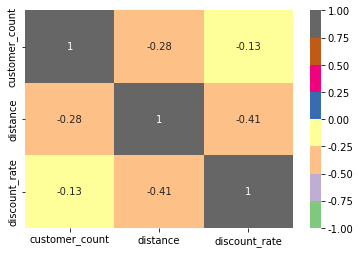

In [21]:
#用热力图展示相关系数(data:相关系数，annot：显示相关系数值，cmap：颜色范围，vmax：最大值，vmin：最小值)
sns.heatmap(data=merchant_pop_dis_rate.corr(),annot=True,cmap='Accent',vmax=1,vmin=-1)

In [ ]:
#由图可知：
#1.到店消费人数的多少与顾客到店铺的距离之间呈现负相关，相关系数0.31，在0.3~0.5之间，为低度相关
#2.到店消费人数的多少与优惠打折力度呈现负相关，相关系数0.2，在0~0.3之间，为相关程度极弱
#综上所述，这些店家之所以火爆，应该是物美价廉导致，与距离和优惠力度相关性不大

## 4.1分析每天中优惠券的总体发放量与使用量情况

In [22]:
#业务分析：日期（优惠券的发放日期Date_received，使用日期date）用作图表的x轴
#需要统计每天优惠券发放数量和使用数量

offline['date'].notnull().sum()  #77.7万消费数据

768767

In [23]:
offline['date_received'].notnull().sum()  #已经发送出105万优惠券

947279

In [24]:
#取出存在消费日期的记录，进行升序，再去重
date_sort = offline[offline['date'].notnull()]['date'].sort_values().unique()
date_sort[:5]

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
#取出存在领券日期的记录，进行升序，再去重
date_receive_sort = offline[offline['date_received'].notnull()]['date_received'].sort_values().unique()
date_receive_sort[:5]

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [26]:
#每天优惠券的使用量（即持券消费人群）
consume_num_everday =  cpon_consume[['user_id','date_received']]
consume_num_everday = consume_num_everday.groupby('date_received').count()
consume_num_everday = consume_num_everday.rename(columns={'user_id':'count'})
consume_num_everday

,count
date_received,
2016-01-01,53
2016-01-02,54
2016-01-03,63
2016-01-04,75
2016-01-05,87
...,...
2016-06-11,306
2016-06-12,285
2016-06-13,376


In [27]:
#每天发放的优惠券数量(取出所有领券日期！=null的数据，在进行按天分组，计数就可以)
coupon_sendout_everyday = offline[offline['date_received'].notnull()][['date_received','user_id']]
coupon_sendout_everyday = coupon_sendout_everyday.groupby('date_received').count()
coupon_sendout_everyday = coupon_sendout_everyday.rename(columns={'user_id':'count'})
coupon_sendout_everyday

,count
date_received,
2016-01-01,447
2016-01-02,439
2016-01-03,429
2016-01-04,474
2016-01-05,579
...,...
2016-06-11,4719
2016-06-12,3638
2016-06-13,6565


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (182,) and arg 1 with shape (167,).

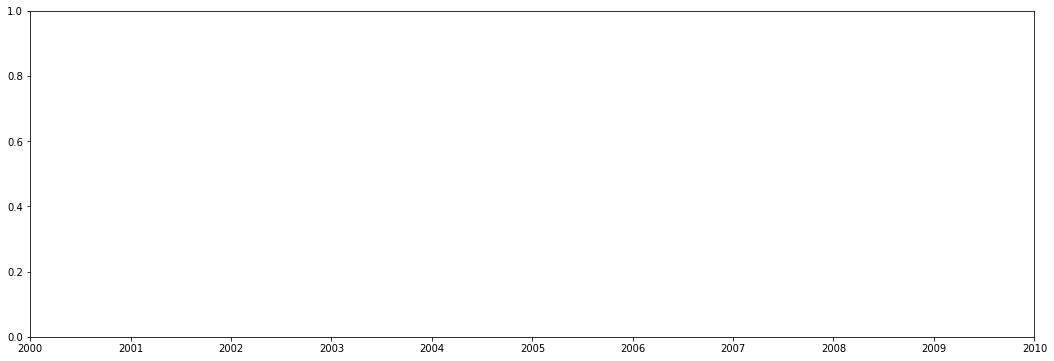

In [28]:
#绘制每天发券量和每天用券量
plt.figure(figsize=(18,6))
# plt.bar(x=date_receive_sort,height=coupon_sendout_everyday['count'],label='每天发券量')
plt.bar(x=date_sort,height=consume_num_everday['count'],label='每天用券量')
plt.yscale('log')  #对y轴进行对数缩放
plt.legend()
#16年2月为例，用券量级别再1000，发券量再10万左右，在100倍左右，优惠券的使用率还是非常低的

/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


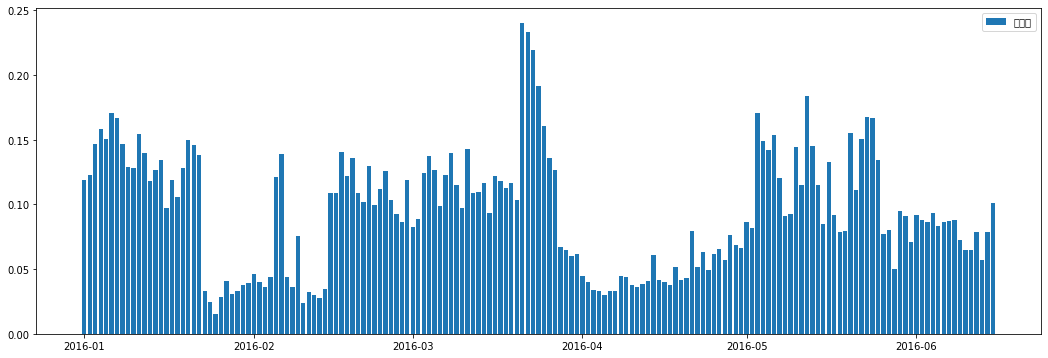

In [29]:
#计算每天的优惠券与发券量占比
plt.figure(figsize=(18,6))
plt.bar(x=date_receive_sort,height=consume_num_everday['count']/coupon_sendout_everyday['count'],
       label='百分比')
plt.legend()

In [ ]:
#由图可知，优惠券使用率最高在16年3月底，达到了30%
#使用率最低在16年1月底，最低为3%左右。
#整体来看，优惠券使用率波动较大。swq